# Relatório de Análise de Evasão de Clientes (Churn) - Telecom X
## 1. Introdução
A evasão de clientes, ou churn, é um desafio significativo para a Telecom X, impactando diretamente a receita e a sustentabilidade. Este relatório detalha a análise de dados com o objetivo de identificar padrões e fatores críticos associados ao cancelamento de serviços, fornecendo insights acionáveis para mitigar a evasão. As métricas-chave analisadas incluem a taxa geral de evasão, as diferenças entre clientes que evadiram e os que permaneceram, e o impacto de variáveis como tipo de contrato, gastos mensais e serviços adicionais.

## 2. Metodologia
O processo de análise foi dividido em três etapas principais: extração, transformação e análise dos dados.

2.1. Extração de Dados
Os dados brutos foram obtidos de uma API no formato JSON.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json

# Configurações de visualização
plt.style.use('ggplot')
sns.set_palette('pastel')

# URL da API
URL_API = "https://raw.githubusercontent.com/anandamatos/telecom-x/refs/heads/master/data/raw/telecom-x_data.json"

# Extração e carregamento dos dados
try:
    response = requests.get(URL_API)
    response.raise_for_status()  # Levanta um erro para status de resposta ruins (4xx ou 5xx)
    data = response.json()
    df = pd.DataFrame(data)
    print(f"Dados extraídos com sucesso. Shape inicial: {df.shape}")
except requests.exceptions.RequestException as e:
    print(f"Erro ao extrair dados da API: {e}")
    df = pd.DataFrame() # Cria DataFrame vazio em caso de erro

Dados extraídos com sucesso. Shape inicial: (7267, 6)


### 2.2. Transformação de Dados
Esta etapa envolveu a limpeza, padronização e criação de novas variáveis para preparar os dados para a análise.

In [2]:
if not df.empty:
    print("\n--- Início da Transformação de Dados ---")

    # 1. Verificação e Remoção de Duplicatas
    print("\n[1/6] Verificando e removendo duplicatas por 'customerID'...")
    initial_records = len(df)
    df.drop_duplicates(subset=['customerID'], keep='first', inplace=True)
    if len(df) < initial_records:
        print(f"Total de registros duplicados removidos: {initial_records - len(df)}")
    else:
        print("Nenhum registro duplicado encontrado.")
    print(f"Registros após remoção de duplicatas: {len(df)}")

    # 2. Desaninhamento de Dados JSON
    print("\n[2/6] Desaninhando dados JSON aninhados (customer, phone, internet, account)...")
    if isinstance(df.iloc[0].get('customer', None), dict):
        df = pd.concat([
            df.drop(['customer', 'phone', 'internet', 'account'], axis=1, errors='ignore'),
            pd.json_normalize(df['customer']),
            pd.json_normalize(df['phone']),
            pd.json_normalize(df['internet']),
            pd.json_normalize(df['account'])
        ], axis=1)
        print("Dados JSON desaninhados com sucesso.")
    else:
        print("Nenhum dado JSON aninhado para desaninhar.")

    # 3. Padronização de Nomes de Colunas
    print("\n[3/6] Padronizando nomes de colunas...")
    column_mapping = {
        'customerID': 'customerID',
        'customer_gender': 'gender',
        'customer_SeniorCitizen': 'SeniorCitizen',
        'customer_Partner': 'Partner',
        'customer_Dependents': 'Dependents',
        'customer_tenure': 'tenure',
        'phone_PhoneService': 'PhoneService',
        'phone_MultipleLines': 'MultipleLines',
        'internet_InternetService': 'InternetService',
        'internet_OnlineSecurity': 'OnlineSecurity',
        'internet_OnlineBackup': 'OnlineBackup',
        'internet_DeviceProtection': 'DeviceProtection',
        'internet_TechSupport': 'TechSupport',
        'internet_StreamingTV': 'StreamingTV',
        'internet_StreamingMovies': 'StreamingMovies',
        'account_Contract': 'Contract',
        'account_PaperlessBilling': 'PaperlessBilling',
        'account_PaymentMethod': 'PaymentMethod',
        'account_Charges.Monthly': 'Charges.Monthly',
        'account_Charges.Total': 'Charges.Total',
        'account_Churn': 'Churn'
    }
    df.rename(columns=column_mapping, inplace=True)
    print("Nomes de colunas padronizados.")

    # 4. Tratamento de Dados Faltantes
    print("\n[4/6] Tratando valores ausentes...")
    # Convertendo 'Charges.Total' para numérico, tratando erros
    df['Charges.Total'] = pd.to_numeric(df['Charges.Total'], errors='coerce')

    # Preenchendo valores ausentes
    # 'tenure' e 'Charges.Total' para clientes sem histórico (tenure=0)
    df.loc[df['tenure'] == 0, 'Charges.Total'] = 0
    df['tenure'].fillna(0, inplace=True)

    # Para outras colunas, preencher com moda para categóricas e mediana para numéricas
    for col in df.columns:
        if df[col].isnull().any():
            if df[col].dtype == 'object':
                df[col].fillna(df[col].mode()[0], inplace=True)
            elif df[col].dtype in ['int64', 'float64']:
                df[col].fillna(df[col].median(), inplace=True)
    print("Valores ausentes tratados.")

    # 5. Verificação e Tratamento de Inconsistências Categóricas
    print("\n[5/6] Verificando e tratando inconsistências em variáveis categóricas...")
    categorical_checks = {
        'gender': ['Male', 'Female'],
        'Partner': ['Yes', 'No'],
        'Dependents': ['Yes', 'No'],
        'PhoneService': ['Yes', 'No'],
        'MultipleLines': ['Yes', 'No', 'No phone service'],
        'InternetService': ['DSL', 'Fiber optic', 'No'],
        'OnlineSecurity': ['Yes', 'No', 'No internet service'],
        'OnlineBackup': ['Yes', 'No', 'No internet service'],
        'DeviceProtection': ['Yes', 'No', 'No internet service'],
        'TechSupport': ['Yes', 'No', 'No internet service'],
        'StreamingTV': ['Yes', 'No', 'No internet service'],
        'StreamingMovies': ['Yes', 'No', 'No internet service'],
        'Contract': ['Month-to-month', 'One year', 'Two year'],
        'PaperlessBilling': ['Yes', 'No'],
        'PaymentMethod': ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'],
        'Churn': ['Yes', 'No']
    }

    for col, valid_values in categorical_checks.items():
        if col in df.columns and df[col].dtype == 'object':
            invalid_values = df[~df[col].isin(valid_values)][col].unique()
            if len(invalid_values) > 0:
                print(f"  - Inconsistências encontradas em '{col}': {invalid_values}. Corrigindo para 'Unknown' ou valor padrão.")
                # Tenta mapear valores comuns antes de genericamente para 'Unknown'
                if col == 'MultipleLines':
                    df[col].replace({'No phone service': 'No'}, inplace=True)
                elif col in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
                    df[col].replace({'No internet service': 'No'}, inplace=True)
                else:
                    df.loc[~df[col].isin(valid_values), col] = df[col].mode()[0] # Substitui por valor mais comum

    # 6. Criação e Refinamento da Coluna 'Contas_Diarias'
    print("\n[6/6] Criando e refinando a coluna 'Contas_Diarias'...")
    # 'Contas_Diarias' baseada na cobrança mensal
    df['Contas_Diarias_Mensal'] = df['Charges.Monthly'].fillna(0) / 30

    # 'Contas_Diarias_Total' baseada na cobrança total e tempo de contrato para clientes com histórico
    with np.errstate(divide='ignore', invalid='ignore'):
        df['Contas_Diarias_Total'] = np.where(
            (df['tenure'] > 0) & (df['Charges.Total'].notna()),
            df['Charges.Total'] / (df['tenure'] * 30),
            np.nan
        )

    # Consolidação: prioriza Contas_Diarias_Total quando disponível, senão usa Contas_Diarias_Mensal
    df['Contas_Diarias'] = df['Contas_Diarias_Total'].fillna(df['Contas_Diarias_Mensal'])
    df['Contas_Diarias'].fillna(0, inplace=True) # Garante que não há NaNs remanescentes
    df['Contas_Diarias'] = df['Contas_Diarias'].round(2)

    # Limpeza de colunas intermediárias
    df.drop(columns=['Contas_Diarias_Mensal', 'Contas_Diarias_Total'], inplace=True, errors='ignore')
    print("Coluna 'Contas_Diarias' criada e refinada.")

    # Padronização e Transformação de Dados (Opcional - mas importante para análise posterior)
    print("\n--- Padronização e Transformação de Dados Categóricos/Numéricos (Opcional) ---")

    # Renomear colunas para português para facilitar a compreensão
    mapeamento_colunas_pt = {
        'gender': 'Genero', 'SeniorCitizen': 'TerceiraIdade', 'Partner': 'TemParceiro',
        'Dependents': 'TemDependentes', 'tenure': 'MesesContrato',
        'PhoneService': 'ServicoTelefone', 'MultipleLines': 'MultiplasLinhas',
        'InternetService': 'ServicoInternet', 'OnlineSecurity': 'SegurancaOnline',
        'OnlineBackup': 'BackupOnline', 'DeviceProtection': 'ProtecaoDispositivo',
        'TechSupport': 'SuporteTecnico', 'StreamingTV': 'TVStreaming',
        'StreamingMovies': 'FilmesStreaming', 'Contract': 'TipoContrato',
        'PaperlessBilling': 'FaturaDigital', 'PaymentMethod': 'MetodoPagamento',
        'Charges.Monthly': 'CobrancaMensal', 'Charges.Total': 'CobrancaTotal',
        'Churn': 'Evasao'
    }
    df.rename(columns={col: mapeamento_colunas_pt[col] for col in mapeamento_colunas_pt if col in df.columns}, inplace=True)
    print("Colunas renomeadas para português.")

    # Transformação de Variáveis Categóricas para Numéricas (quando aplicável)
    # Binárias (Sim/Não para 1/0)
    colunas_binarias_pt = ['TemParceiro', 'TemDependentes', 'ServicoTelefone', 'FaturaDigital', 'TerceiraIdade']
    for col in colunas_binarias_pt:
        if col in df.columns:
            df[col] = df[col].map({'Yes': 1, 'No': 0, 'Sim': 1, 'Não': 0, True: 1, False: 0}).fillna(df[col]) # Mantém outros valores se não mapeados
    print("Variáveis binárias transformadas.")

    # Serviços adicionais (Yes/No/No internet service para 1/0)
    servicos_pt = ['SegurancaOnline', 'BackupOnline', 'ProtecaoDispositivo', 'SuporteTecnico', 'TVStreaming', 'FilmesStreaming']
    for col in servicos_pt:
        if col in df.columns:
            df[col] = df[col].replace({'No internet service': 'No', 'Sem serviço de internet': 'No'})
            df[col] = df[col].map({'Yes': 1, 'No': 0, 'Sim': 1, 'Não': 0}).fillna(df[col])
    print("Variáveis de serviço transformadas.")

    # Gênero
    if 'Genero' in df.columns:
        df['Genero'] = df['Genero'].map({'Male': 'Masculino', 'Female': 'Feminino'})
    print("Variável 'Genero' padronizada.")

    # Evasao (Churn) para numérico
    if 'Evasao' in df.columns and df['Evasao'].dtype == 'object':
        df['Evasao'] = df['Evasao'].map({'Yes': 1, 'No': 0}).fillna(df['Evasao'])
    print("Variável 'Evasao' convertida para numérica.")

    # Criação de Variáveis Derivadas
    if 'MesesContrato' in df.columns:
        df['TipoCliente'] = pd.cut(df['MesesContrato'],
                                   bins=[0, 6, 12, 24, float('inf')],
                                   labels=['Novo', 'Intermediário', 'Antigo', 'Muito Antigo'],
                                   right=False) # Inclui o limite inferior
    if all(col in df.columns for col in ['CobrancaTotal', 'MesesContrato']):
        df['ValorMedioMensal'] = df['CobrancaTotal'] / df['MesesContrato'].replace(0, np.nan) # Evita divisão por zero
        df['ValorMedioMensal'].fillna(df['CobrancaMensal'], inplace=True) # Se mesesContrato é 0, usa cobrança mensal
        df['ValorMedioMensal'].fillna(0, inplace=True) # Preenche quaisquer NaNs restantes

    print("\n--- Transformação concluída com sucesso! ---")
    print(f"Total de registros válidos: {len(df)}")
    print("\nResumo final dos dados:")
    df.info()
else:
    print("\nDataFrame vazio. Nenhuma transformação realizada.")


--- Início da Transformação de Dados ---

[1/6] Verificando e removendo duplicatas por 'customerID'...
Nenhum registro duplicado encontrado.
Registros após remoção de duplicatas: 7267

[2/6] Desaninhando dados JSON aninhados (customer, phone, internet, account)...
Dados JSON desaninhados com sucesso.

[3/6] Padronizando nomes de colunas...
Nomes de colunas padronizados.

[4/6] Tratando valores ausentes...
Valores ausentes tratados.

[5/6] Verificando e tratando inconsistências em variáveis categóricas...
  - Inconsistências encontradas em 'Churn': ['']. Corrigindo para 'Unknown' ou valor padrão.

[6/6] Criando e refinando a coluna 'Contas_Diarias'...
Coluna 'Contas_Diarias' criada e refinada.

--- Padronização e Transformação de Dados Categóricos/Numéricos (Opcional) ---
Colunas renomeadas para português.
Variáveis binárias transformadas.
Variáveis de serviço transformadas.
Variável 'Genero' padronizada.
Variável 'Evasao' convertida para numérica.

--- Transformação concluída com suce

<ipython-input-2-fbc580ef3289>:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['tenure'].fillna(0, inplace=True)
<ipython-input-2-fbc580ef3289>:124: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.metho

## 3. Análise Descritiva e Exploratória (EDA)
Esta seção apresenta uma visão geral das características dos dados, incluindo estatísticas descritivas, distribuições de variáveis categóricas e numéricas, e a relação entre elas e a evasão.

### 3.1. Estatísticas Descritivas


--- Análise Descritiva dos Dados ---

1. Estatísticas Descritivas Básicas (Variáveis Numéricas):
                      count     mean      std    min     25%      50%  \
Evasao               7267.0     0.26     0.44   0.00    0.00     0.00   
TerceiraIdade        7267.0     0.16     0.37   0.00    0.00     0.00   
TemParceiro          7267.0     0.48     0.50   0.00    0.00     0.00   
TemDependentes       7267.0     0.30     0.46   0.00    0.00     0.00   
MesesContrato        7267.0    32.35    24.57   0.00    9.00    29.00   
ServicoTelefone      7267.0     0.90     0.30   0.00    1.00     1.00   
SegurancaOnline      7267.0     0.29     0.45   0.00    0.00     0.00   
BackupOnline         7267.0     0.34     0.48   0.00    0.00     0.00   
ProtecaoDispositivo  7267.0     0.34     0.47   0.00    0.00     0.00   
SuporteTecnico       7267.0     0.29     0.45   0.00    0.00     0.00   
TVStreaming          7267.0     0.38     0.49   0.00    0.00     0.00   
FilmesStreaming      7267.

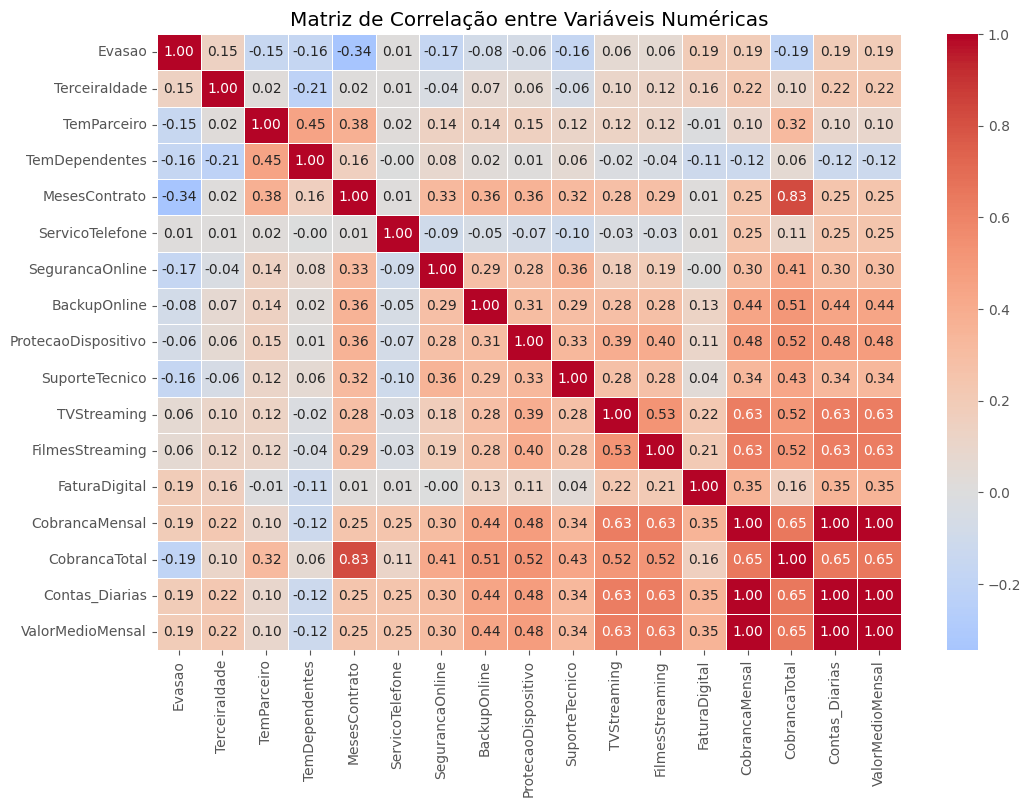


  a. Top Correlações com Evasão:
MesesContrato      -0.34
CobrancaTotal      -0.19
CobrancaMensal      0.19
Contas_Diarias      0.19
ValorMedioMensal    0.19
FaturaDigital       0.19
SegurancaOnline    -0.17
TemDependentes     -0.16
SuporteTecnico     -0.16
TemParceiro        -0.15
TerceiraIdade       0.15
Name: Evasao, dtype: float64

--- Análise Descritiva concluída. ---


In [3]:
if not df.empty:
    print("\n--- Análise Descritiva dos Dados ---")

    print("\n1. Estatísticas Descritivas Básicas (Variáveis Numéricas):")
    numeric_cols = df.select_dtypes(include=['number']).columns
    if 'customerID' in numeric_cols:
        numeric_cols = numeric_cols.drop('customerID') # Remove customerID se for numérico

    if len(numeric_cols) > 0:
        description_numeric = df[numeric_cols].describe(percentiles=[.25, .5, .75]).transpose()
        description_numeric['IQR'] = description_numeric['75%'] - description_numeric['25%']
        print(description_numeric[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'IQR']].round(2))
    else:
        print("Nenhuma variável numérica encontrada para análise descritiva.")

    print("\n2. Distribuição de Variáveis Categóricas:")
    categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns

    for col in categorical_cols:
        print(f"\nVariável: {col}")
        count_series = df[col].value_counts(dropna=False)
        percentage_series = df[col].value_counts(normalize=True, dropna=False) * 100
        distribution_df = pd.DataFrame({'Contagem': count_series, 'Percentual (%)': percentage_series.round(2)})
        print(distribution_df)

    # Análise Segmentada por Evasão (Churn)
    if 'Evasao' in df.columns:
        print("\n3. Análise Comparativa: Clientes que Evadiram vs. Permaneceram")

        # Métricas numéricas comparativas
        print("\n  a. Métricas Numéricas por Status de Evasão:")
        if len(numeric_cols) > 0:
            print(df.groupby('Evasao')[numeric_cols].agg(['mean', 'median', 'std', 'min', 'max']).round(2))
        else:
            print("Nenhuma variável numérica para comparação por evasão.")

        # Distribuição de categorias por evasão
        print("\n  b. Distribuição de Categorias por Status de Evasão:")
        for col in categorical_cols:
            if col != 'Evasao':
                print(f"\n    Variável: {col}")
                cross_tab = pd.crosstab(df[col], df['Evasao'], normalize='index') * 100
                cross_tab.columns = ['Permaneceram (%)', 'Evadiram (%)']
                cross_tab['Total Clientes'] = df[col].value_counts()
                print(cross_tab.round(2).sort_values('Evadiram (%)', ascending=False))

    # Análise de Correlações
    print("\n4. Matriz de Correlação entre Variáveis Numéricas:")
    if len(numeric_cols) > 1:
        plt.figure(figsize=(12, 8))
        correlations = df[numeric_cols].corr()
        sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=.5)
        plt.title('Matriz de Correlação entre Variáveis Numéricas')
        plt.show()

        if 'Evasao' in numeric_cols:
            churn_correlations = correlations['Evasao'].sort_values(key=abs, ascending=False)
            print("\n  a. Top Correlações com Evasão:")
            print(churn_correlations[abs(churn_correlations) > 0.1].drop('Evasao').round(2))
    else:
        print("Não há variáveis numéricas suficientes para calcular a matriz de correlação.")

    print("\n--- Análise Descritiva concluída. ---")

### 3.2. Análise da Distribuição da Evasão


--- Análise da Distribuição da Evasão ---

1. Proporção de Clientes por Status de Evasão:
        Clientes  Percentual (%)
Evasao                          
0           5398           74.28
1           1869           25.72

2. Visualização da Distribuição de Evasão:


<ipython-input-4-82028db7203e>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Evasao', data=df, palette='viridis')


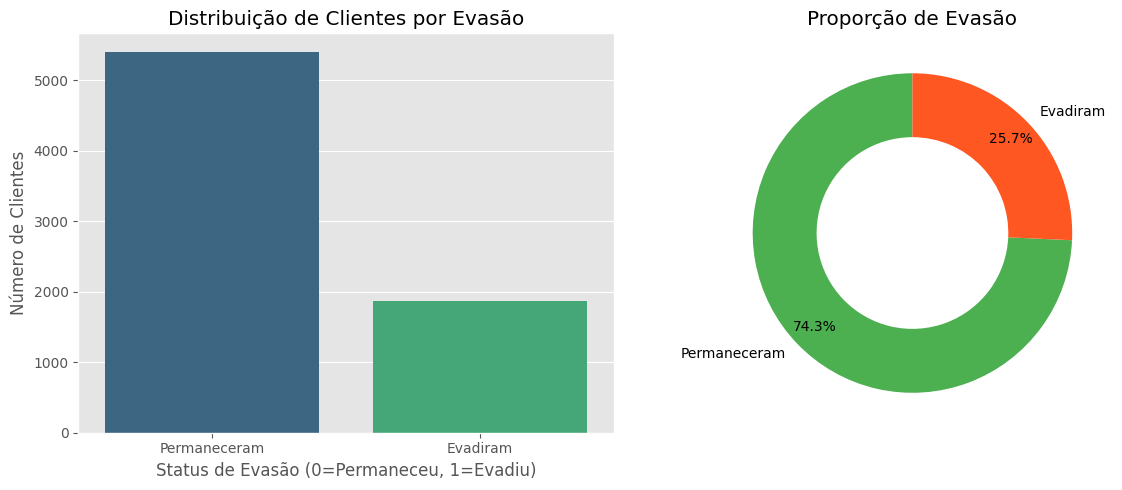


3. Distribuição de Evasão por Tipo de Contrato:


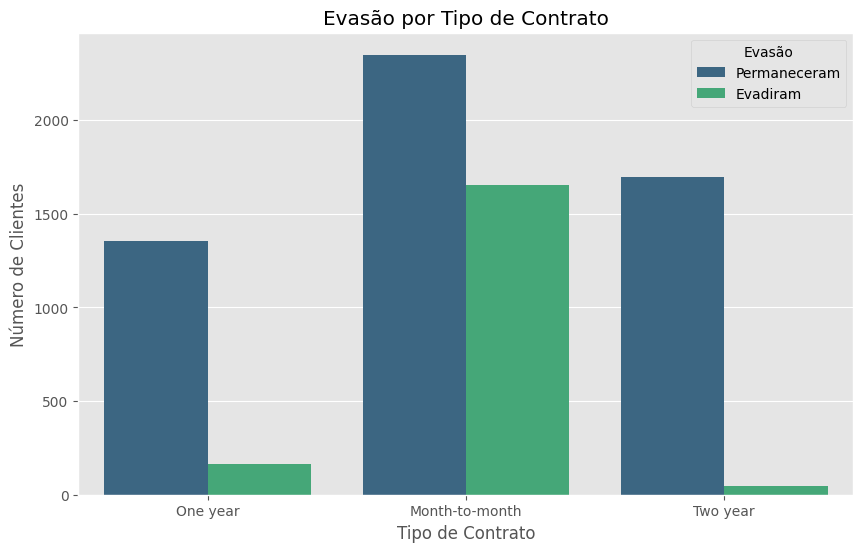


4. Distribuição de Evasão por Tipo de Serviço de Internet:


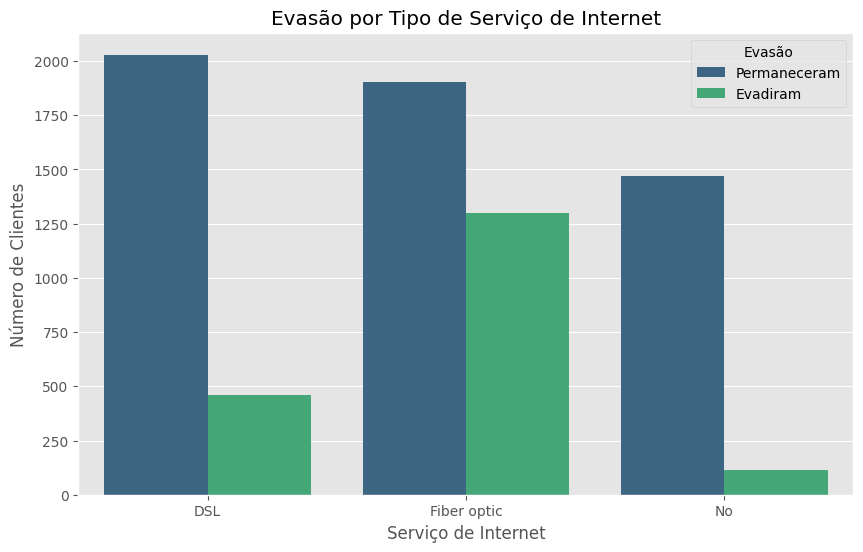

In [4]:
if not df.empty and 'Evasao' in df.columns:
    print("\n--- Análise da Distribuição da Evasão ---")

    print("\n1. Proporção de Clientes por Status de Evasão:")
    churn_distribution = df['Evasao'].value_counts(dropna=False)
    churn_percentage = df['Evasao'].value_counts(normalize=True, dropna=False) * 100
    churn_table = pd.DataFrame({'Clientes': churn_distribution, 'Percentual (%)': churn_percentage.round(2)})
    print(churn_table)

    print("\n2. Visualização da Distribuição de Evasão:")
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.countplot(x='Evasao', data=df, palette='viridis')
    plt.title('Distribuição de Clientes por Evasão')
    plt.xlabel('Status de Evasão (0=Permaneceu, 1=Evadiu)')
    plt.ylabel('Número de Clientes')
    plt.xticks([0, 1], ['Permaneceram', 'Evadiram'])

    plt.subplot(1, 2, 2)
    df['Evasao'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#4CAF50', '#FF5722'], startangle=90,
                                         labels=['Permaneceram', 'Evadiram'],
                                         pctdistance=0.85, wedgeprops=dict(width=0.4))
    plt.title('Proporção de Evasão')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

    print("\n3. Distribuição de Evasão por Tipo de Contrato:")
    if 'TipoContrato' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(x='TipoContrato', hue='Evasao', data=df, palette='viridis')
        plt.title('Evasão por Tipo de Contrato')
        plt.xlabel('Tipo de Contrato')
        plt.ylabel('Número de Clientes')
        plt.legend(title='Evasão', labels=['Permaneceram', 'Evadiram'])
        plt.show()

    print("\n4. Distribuição de Evasão por Tipo de Serviço de Internet:")
    if 'ServicoInternet' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(x='ServicoInternet', hue='Evasao', data=df, palette='viridis')
        plt.title('Evasão por Tipo de Serviço de Internet')
        plt.xlabel('Serviço de Internet')
        plt.ylabel('Número de Clientes')
        plt.legend(title='Evasão', labels=['Permaneceram', 'Evadiram'])
        plt.show()
else:
    print("Coluna 'Evasao' não encontrada ou DataFrame vazio. Não foi possível analisar a distribuição de evasão.")

### 3.3. Análise de Evasão por Variáveis Categóricas


--- Análise de Evasão por Variáveis Categóricas ---

1. Proporção de Evasão por Categoria:

>> Variável: Genero
           Permaneceram (%)  Evadiram (%)  Total Clientes
Genero                                                   
Feminino              73.86         26.14            3592
Masculino             74.69         25.31            3675

>> Variável: TipoContrato
                Permaneceram (%)  Evadiram (%)  Total Clientes
TipoContrato                                                  
Month-to-month             58.68         41.32            4005
One year                   89.07         10.93            1519
Two year                   97.25          2.75            1743

>> Variável: MetodoPagamento
                           Permaneceram (%)  Evadiram (%)  Total Clientes
MetodoPagamento                                                          
Electronic check                      56.20         43.80            2445
Mailed check                          81.50         18.50    

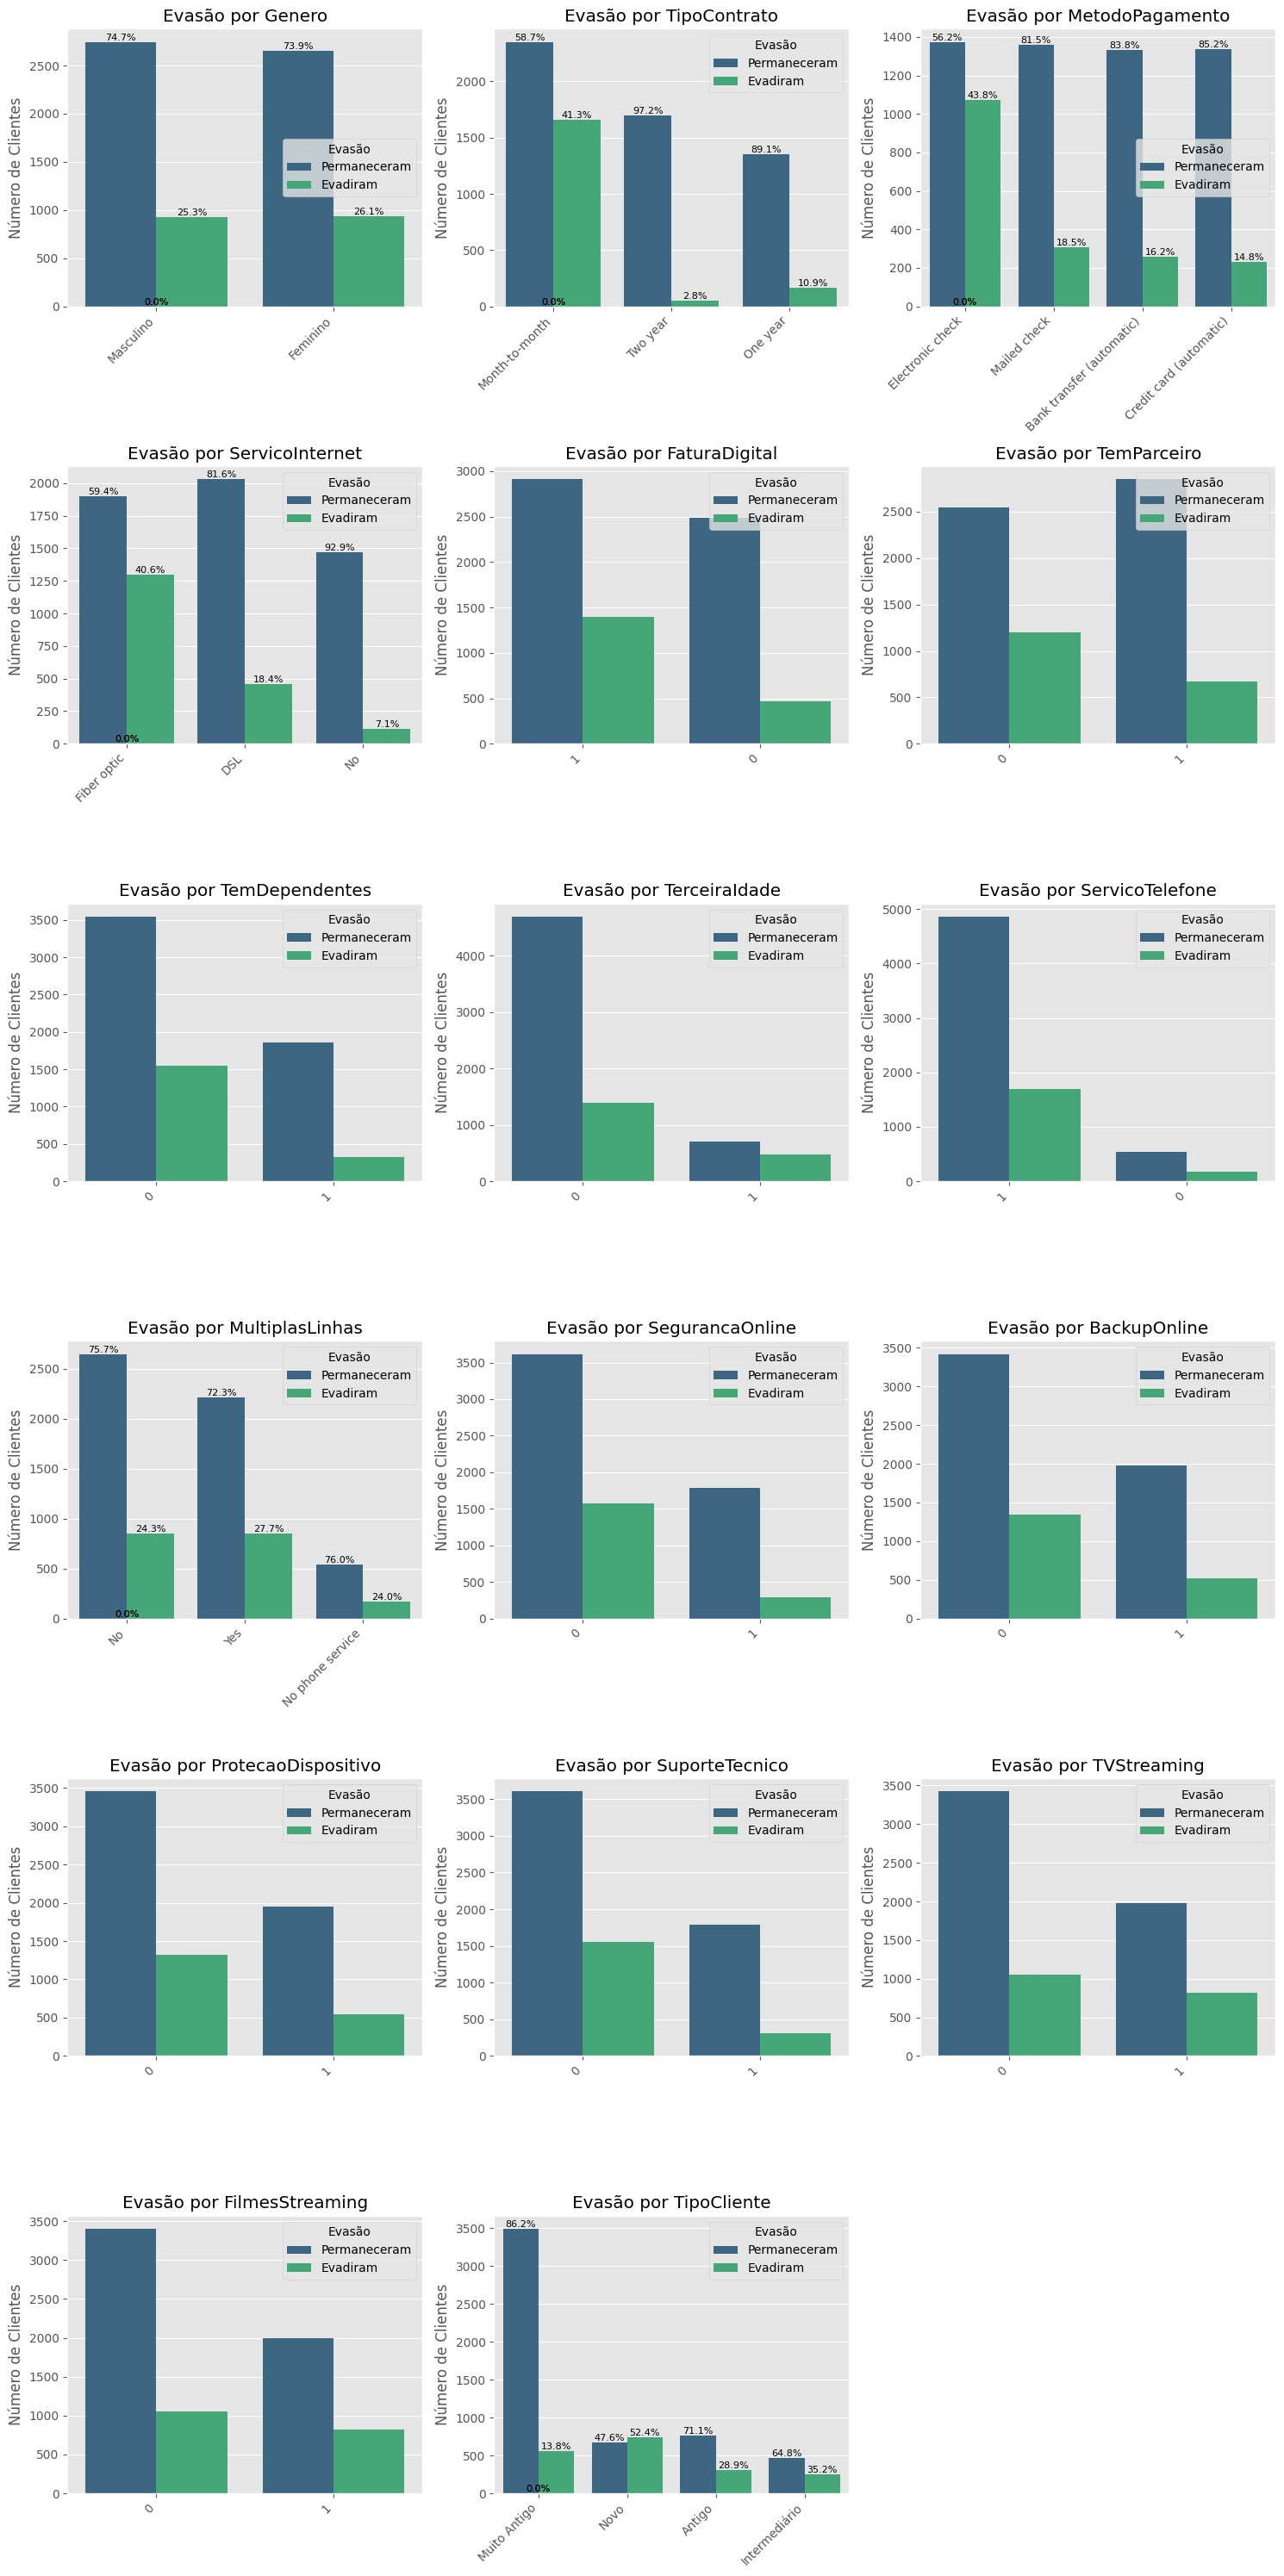


3. Principais Insights por Variável Categórica:

Genero:
- Maior taxa de evasão: Feminino (26.1%)
- Menor taxa de evasão: Masculino (25.3%)

TipoContrato:
- Maior taxa de evasão: Month-to-month (41.3%)
- Menor taxa de evasão: Two year (2.8%)

MetodoPagamento:
- Maior taxa de evasão: Electronic check (43.8%)
- Menor taxa de evasão: Credit card (automatic) (14.8%)

ServicoInternet:
- Maior taxa de evasão: Fiber optic (40.6%)
- Menor taxa de evasão: No (7.1%)

MultiplasLinhas:
- Maior taxa de evasão: Yes (27.7%)
- Menor taxa de evasão: No phone service (24.0%)

TipoCliente:
- Maior taxa de evasão: Novo (52.4%)
- Menor taxa de evasão: Muito Antigo (13.8%)


<ipython-input-5-b669660f06bd>:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rate = df.groupby(var)['Evasao'].mean().sort_values(ascending=False) * 100


In [5]:
if not df.empty and 'Evasao' in df.columns:
    print("\n--- Análise de Evasão por Variáveis Categóricas ---")

    categorical_vars = [
        'Genero', 'TipoContrato', 'MetodoPagamento', 'ServicoInternet',
        'FaturaDigital', 'TemParceiro', 'TemDependentes', 'TerceiraIdade',
        'ServicoTelefone', 'MultiplasLinhas', 'SegurancaOnline', 'BackupOnline',
        'ProtecaoDispositivo', 'SuporteTecnico', 'TVStreaming', 'FilmesStreaming',
        'TipoCliente'
    ]
    # Filtrar apenas as colunas que existem no DataFrame
    categorical_vars_present = [v for v in categorical_vars if v in df.columns]

    print("\n1. Proporção de Evasão por Categoria:")
    for var in categorical_vars_present:
        print(f"\n>> Variável: {var}")
        if df[var].dtype == 'object' or df[var].dtype == 'category' or df[var].dtype == 'bool':
            cross_tab = pd.crosstab(df[var], df['Evasao'], normalize='index') * 100
            cross_tab.columns = ['Permaneceram (%)', 'Evadiram (%)']
            cross_tab['Total Clientes'] = df[var].value_counts()
            print(cross_tab.round(2).sort_values('Evadiram (%)', ascending=False))
        else:
            print(f"  '{var}' não é uma variável categórica. Ignorando.")

    print("\n2. Visualização da Evasão por Categoria:")
    num_plots = len(categorical_vars_present)
    n_cols = 3
    n_rows = (num_plots + n_cols - 1) // n_cols # Calcula o número de linhas necessário

    plt.figure(figsize=(15, 5 * n_rows))

    for i, var in enumerate(categorical_vars_present, 1):
        plt.subplot(n_rows, n_cols, i)
        ax = sns.countplot(x=var, hue='Evasao', data=df, palette='viridis', order=df[var].value_counts().index)

        # Adicionar porcentagens no topo das barras
        total_counts = df[var].value_counts()
        for p in ax.patches:
            height = p.get_height()
            category_label = p.get_x()
            current_category = ax.get_xticklabels()[int(category_label + 0.5)].get_text() # Get category label
            total_for_category = total_counts.get(current_category, 0)
            if total_for_category > 0:
                ax.annotate(f'{height/total_for_category*100:.1f}%',
                            (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='bottom', fontsize=8, color='black')

        plt.title(f'Evasão por {var}')
        plt.xlabel('')
        plt.ylabel('Número de Clientes')
        plt.legend(title='Evasão', labels=['Permaneceram', 'Evadiram'])
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    print("\n3. Principais Insights por Variável Categórica:")
    for var in categorical_vars_present:
        if df[var].dtype == 'object' or df[var].dtype == 'category' or df[var].dtype == 'bool':
            churn_rate = df.groupby(var)['Evasao'].mean().sort_values(ascending=False) * 100
            if not churn_rate.empty:
                highest_churn_category = churn_rate.idxmax()
                highest_churn_value = churn_rate.max()

                lowest_churn_category = churn_rate.idxmin()
                lowest_churn_value = churn_rate.min()

                print(f"\n{var}:")
                print(f"- Maior taxa de evasão: {highest_churn_category} ({highest_churn_value:.1f}%)")
                print(f"- Menor taxa de evasão: {lowest_churn_category} ({lowest_churn_value:.1f}%)")
else:
    print("Coluna 'Evasao' não encontrada ou DataFrame vazio. Não foi possível analisar evasão por variáveis categóricas.")

### 3.4. Análise de Evasão por Variáveis Numéricas



--- Análise de Evasão por Variáveis Numéricas ---

1. Estatísticas Descritivas por Status de Evasão:
       MesesContrato                       CobrancaMensal                \
                mean median    std min max           mean median    std   
Evasao                                                                    
0              37.32   37.0  24.18   0  72          61.35  64.50  31.11   
1              17.98   10.0  19.53   1  72          74.44  79.65  24.67   

                       ... Contas_Diarias                           \
          min     max  ...           mean median   std   min   max   
Evasao                 ...                                           
0       18.25  118.75  ...           2.05   2.14  1.04  0.46  4.02   
1       18.85  118.35  ...           2.48   2.64  0.83  0.47  4.05   

       ValorMedioMensal                               
                   mean median    std    min     max  
Evasao                                                
0     

<ipython-input-6-debe00c65e53>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Evasao', y=var, data=df, palette='viridis')
<ipython-input-6-debe00c65e53>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Evasao', y=var, data=df, palette='viridis')
<ipython-input-6-debe00c65e53>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Evasao', y=var, data=df, palette='viridis')
<ipython-input-6-debe00c65e53>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable

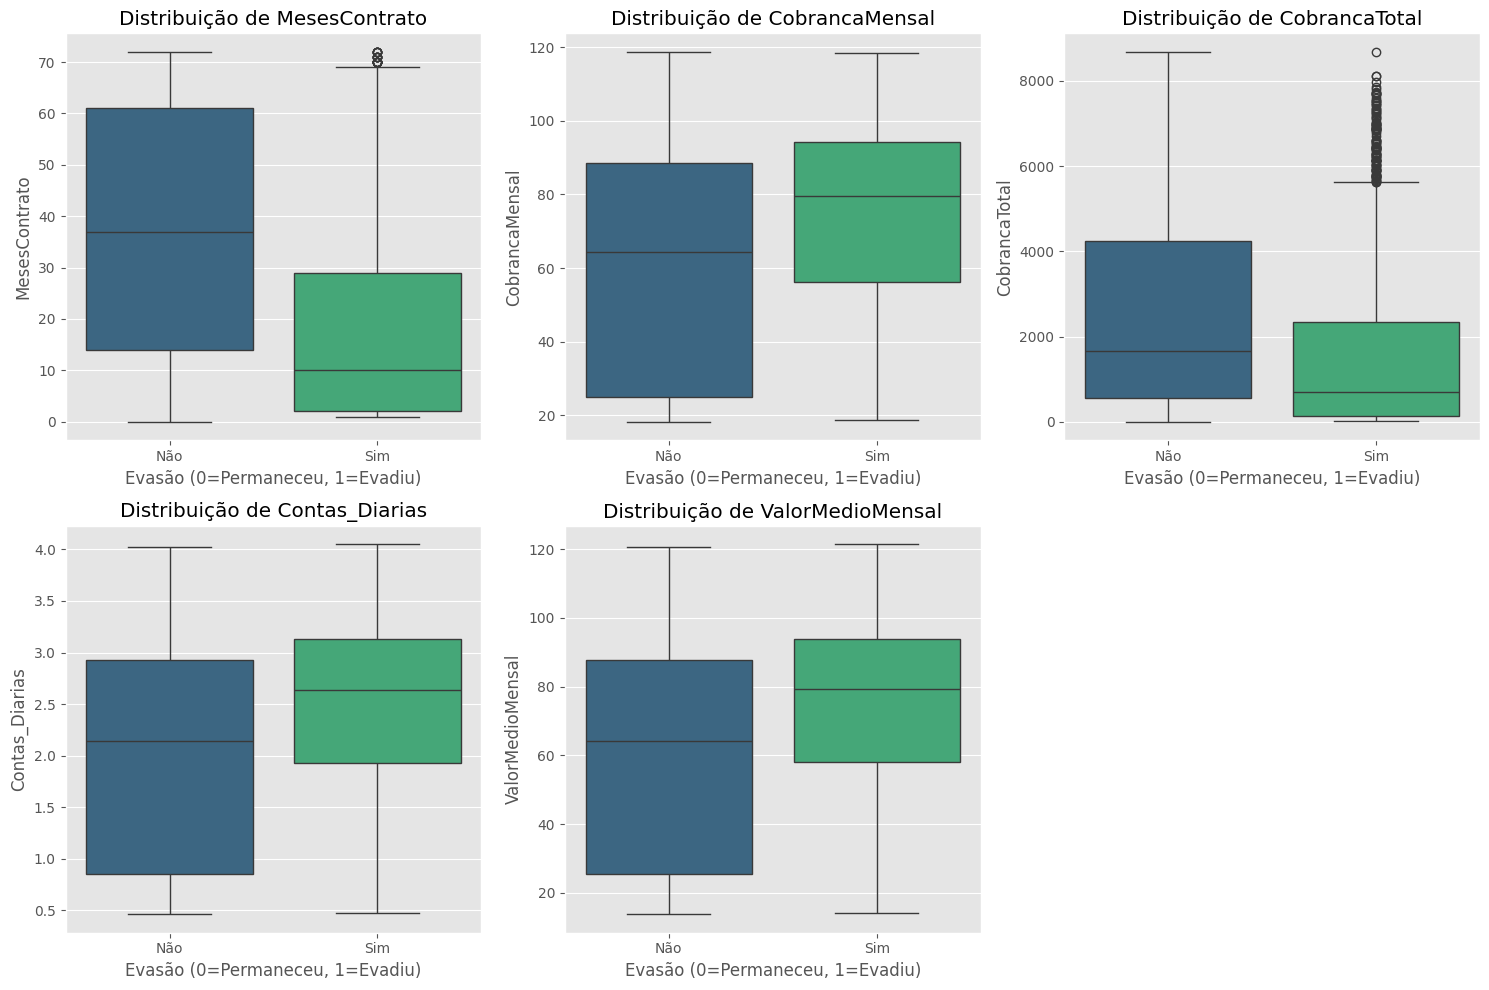


3. Testes Estatísticos (Diferença entre Grupos):

Variável: MesesContrato
- Diferença de médias (Evadiu - Permaneceu): -19.34
- Teste t: estatística = 34.61, p-valor = 0.0000
- Tamanho do efeito (Cohen's d): -0.84

Variável: CobrancaMensal
- Diferença de médias (Evadiu - Permaneceu): 13.09
- Teste t: estatística = -18.42, p-valor = 0.0000
- Tamanho do efeito (Cohen's d): 0.44

Variável: CobrancaTotal
- Diferença de médias (Evadiu - Permaneceu): -1003.47
- Teste t: estatística = 18.57, p-valor = 0.0000
- Tamanho do efeito (Cohen's d): -0.45

Variável: Contas_Diarias
- Diferença de médias (Evadiu - Permaneceu): 0.44
- Teste t: estatística = -18.25, p-valor = 0.0000
- Tamanho do efeito (Cohen's d): 0.44

Variável: ValorMedioMensal
- Diferença de médias (Evadiu - Permaneceu): 13.07
- Teste t: estatística = -18.25, p-valor = 0.0000
- Tamanho do efeito (Cohen's d): 0.44

4. Análise de Limiares Críticos (Médias por Grupo):

MesesContrato:
- Média dos clientes que evadiram: 17.98
- Média dos 

In [6]:
if not df.empty and 'Evasao' in df.columns:
    print("\n--- Análise de Evasão por Variáveis Numéricas ---")

    numeric_churn_vars = ['MesesContrato', 'CobrancaMensal', 'CobrancaTotal', 'Contas_Diarias', 'ValorMedioMensal']
    numeric_churn_vars = [v for v in numeric_churn_vars if v in df.columns]

    if not numeric_churn_vars:
        print("Nenhuma variável numérica relevante para análise de evasão encontrada.")
    else:
        print("\n1. Estatísticas Descritivas por Status de Evasão:")
        stats_by_churn = df.groupby('Evasao')[numeric_churn_vars].agg(['mean', 'median', 'std', 'min', 'max'])
        print(stats_by_churn.round(2))

        print("\n2. Visualização da Distribuição por Evasão:")
        num_plots = len(numeric_churn_vars)
        n_cols = 3
        n_rows = (num_plots + n_cols - 1) // n_cols

        plt.figure(figsize=(15, 5 * n_rows))

        for i, var in enumerate(numeric_churn_vars, 1):
            plt.subplot(n_rows, n_cols, i)
            sns.boxplot(x='Evasao', y=var, data=df, palette='viridis')
            plt.title(f'Distribuição de {var}')
            plt.xlabel('Evasão (0=Permaneceu, 1=Evadiu)')
            plt.ylabel(var)
            plt.xticks([0, 1], ['Não', 'Sim'])
        plt.tight_layout()
        plt.show()

        print("\n3. Testes Estatísticos (Diferença entre Grupos):")
        from scipy import stats
        for var in numeric_churn_vars:
            group_0 = df[df['Evasao'] == 0][var].dropna()
            group_1 = df[df['Evasao'] == 1][var].dropna()

            if len(group_0) > 1 and len(group_1) > 1:
                t_stat, p_val = stats.ttest_ind(group_0, group_1, equal_var=False) # Welch's t-test
                print(f"\nVariável: {var}")
                print(f"- Diferença de médias (Evadiu - Permaneceu): {group_1.mean() - group_0.mean():.2f}")
                print(f"- Teste t: estatística = {t_stat:.2f}, p-valor = {p_val:.4f}")

                # Cohen's d (Tamanho do efeito)
                pooled_std = np.sqrt(((len(group_0) - 1) * group_0.std()**2 + (len(group_1) - 1) * group_1.std()**2) / (len(group_0) + len(group_1) - 2))
                if pooled_std > 0:
                    cohens_d = (group_1.mean() - group_0.mean()) / pooled_std
                    print(f"- Tamanho do efeito (Cohen's d): {cohens_d:.2f}")
                else:
                    print("- Tamanho do efeito: N/A (desvio padrão zero)")
            else:
                print(f"\nVariável: {var} - Não há dados suficientes em um ou ambos os grupos para teste estatístico.")

        print("\n4. Análise de Limiares Críticos (Médias por Grupo):")
        for var in numeric_churn_vars:
            mean_churned = df[df['Evasao'] == 1][var].mean()
            mean_not_churned = df[df['Evasao'] == 0][var].mean()
            print(f"\n{var}:")
            print(f"- Média dos clientes que evadiram: {mean_churned:.2f}")
            print(f"- Média dos clientes que permaneceram: {mean_not_churned:.2f}")
            print(f"- Diferença absoluta: {abs(mean_churned - mean_not_churned):.2f}")
else:
    print("Coluna 'Evasao' não encontrada ou DataFrame vazio. Não foi possível analisar evasão por variáveis numéricas.")

### 3.5. Análise Extra: Correlação entre Variáveis


--- Análise Extra: Correlação entre Variáveis ---
Coluna 'TotalServicos' criada.

1. Matriz de Correlação (Pearson):
                MesesContrato  CobrancaMensal  CobrancaTotal  Contas_Diarias  \
MesesContrato            1.00            0.25           0.83            0.25   
CobrancaMensal           0.25            1.00           0.65            1.00   
CobrancaTotal            0.83            0.65           1.00            0.65   
Contas_Diarias           0.25            1.00           0.65            1.00   
TotalServicos            0.49            0.73           0.75            0.72   
Evasao                  -0.34            0.19          -0.19            0.19   

                TotalServicos  Evasao  
MesesContrato            0.49   -0.34  
CobrancaMensal           0.73    0.19  
CobrancaTotal            0.75   -0.19  
Contas_Diarias           0.72    0.19  
TotalServicos            1.00   -0.08  
Evasao                  -0.08    1.00  


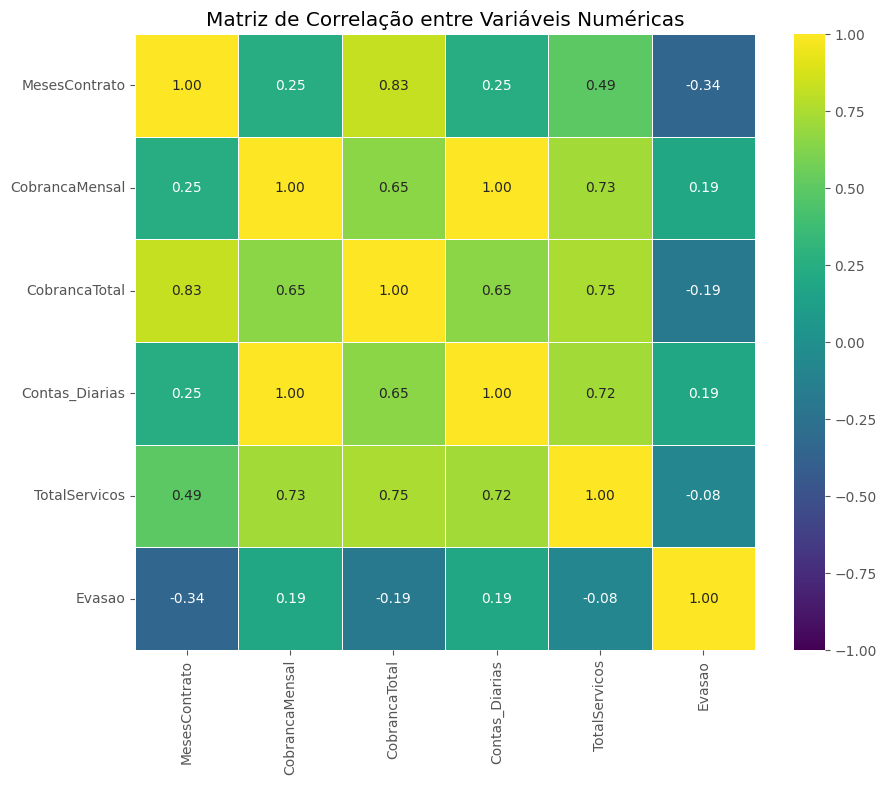


2. Correlação com Evasão:
                Correlação
MesesContrato        -0.34
CobrancaTotal        -0.19
CobrancaMensal        0.19
Contas_Diarias        0.19

3. Relações Chave (Visualizações):


<ipython-input-7-b6906424b66e>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Evasao', y=var, data=df, palette='viridis')
<ipython-input-7-b6906424b66e>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Evasao', y=var, data=df, palette='viridis')
<ipython-input-7-b6906424b66e>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Evasao', y=var, data=df, palette='viridis')


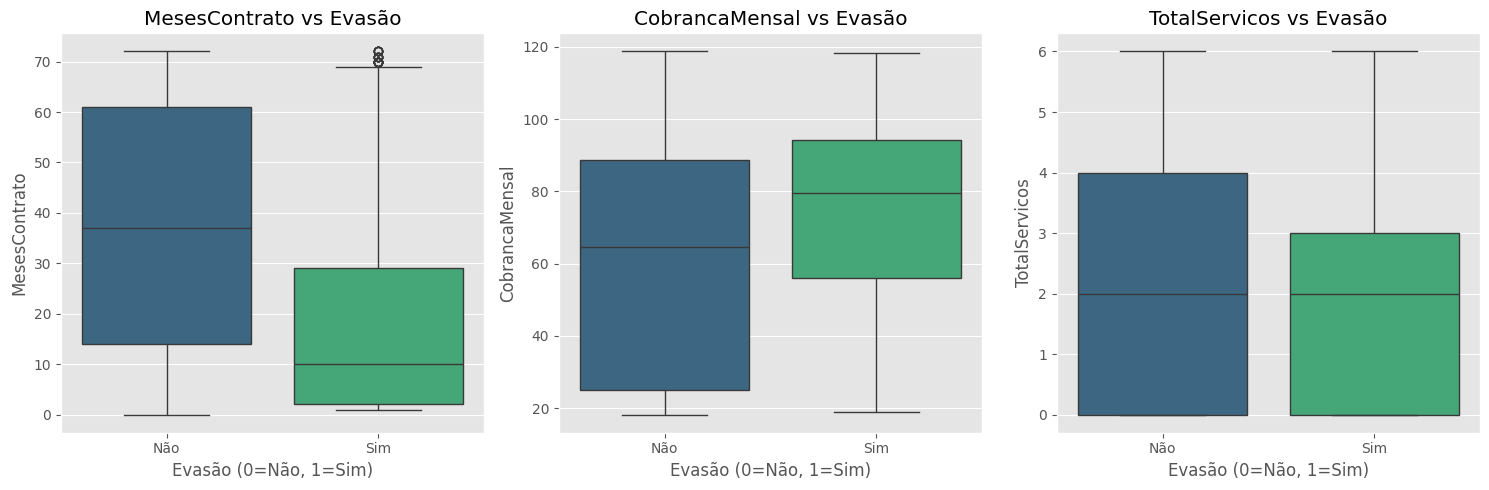


4. Análise de Interação: Meses de Contrato vs. Cobrança Mensal por Evasão


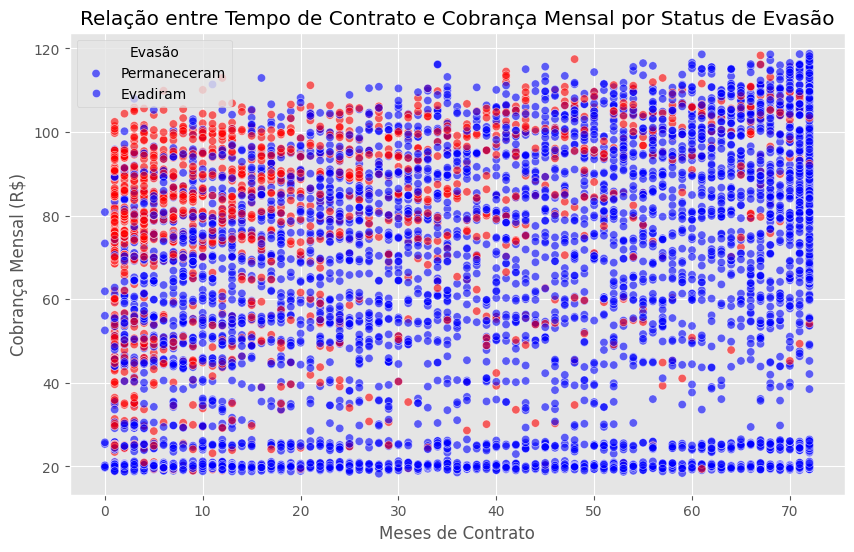

In [7]:
if not df.empty:
    print("\n--- Análise Extra: Correlação entre Variáveis ---")

    # Criar variável 'TotalServicos'
    service_cols_map = {
        'SegurancaOnline': 'OnlineSecurity', 'BackupOnline': 'OnlineBackup',
        'ProtecaoDispositivo': 'DeviceProtection', 'SuporteTecnico': 'TechSupport',
        'TVStreaming': 'StreamingTV', 'FilmesStreaming': 'StreamingMovies'
    }
    present_service_cols = [k for k, v in service_cols_map.items() if k in df.columns]

    if present_service_cols:
        df['TotalServicos'] = df[present_service_cols].sum(axis=1)
        print("Coluna 'TotalServicos' criada.")
    else:
        print("Aviso: Não foi possível criar 'TotalServicos' - colunas de serviços não encontradas ou não numéricas.")

    correlation_vars = ['MesesContrato', 'CobrancaMensal', 'CobrancaTotal', 'Contas_Diarias']
    if 'TotalServicos' in df.columns:
        correlation_vars.append('TotalServicos')
    if 'Evasao' in df.columns:
        correlation_vars.append('Evasao')

    correlation_vars_present = [v for v in correlation_vars if v in df.columns and pd.api.types.is_numeric_dtype(df[v])]

    if len(correlation_vars_present) > 1:
        print("\n1. Matriz de Correlação (Pearson):")
        correlation_matrix = df[correlation_vars_present].corr()
        print(correlation_matrix.round(2))

        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='viridis', center=0, vmin=-1, vmax=1, fmt='.2f', linewidths=.5)
        plt.title('Matriz de Correlação entre Variáveis Numéricas')
        plt.show()

        if 'Evasao' in correlation_vars_present:
            churn_correlations = correlation_matrix['Evasao'].sort_values(key=abs, ascending=False)
            print("\n2. Correlação com Evasão:")
            print(churn_correlations[abs(churn_correlations) > 0.1].drop('Evasao', errors='ignore').to_frame('Correlação').round(2))

        print("\n3. Relações Chave (Visualizações):")
        plot_vars = []
        if 'MesesContrato' in df.columns: plot_vars.append('MesesContrato')
        if 'CobrancaMensal' in df.columns: plot_vars.append('CobrancaMensal')
        if 'TotalServicos' in df.columns: plot_vars.append('TotalServicos')

        if 'Evasao' in df.columns and plot_vars:
            plt.figure(figsize=(15, 5))
            for i, var in enumerate(plot_vars, 1):
                plt.subplot(1, len(plot_vars), i)
                sns.boxplot(x='Evasao', y=var, data=df, palette='viridis')
                plt.title(f'{var} vs Evasão')
                plt.xlabel('Evasão (0=Não, 1=Sim)')
                plt.ylabel(var)
                plt.xticks([0, 1], ['Não', 'Sim'])
            plt.tight_layout()
            plt.show()

        if all(col in df.columns for col in ['CobrancaMensal', 'MesesContrato', 'Evasao']):
            print("\n4. Análise de Interação: Meses de Contrato vs. Cobrança Mensal por Evasão")
            plt.figure(figsize=(10, 6))
            sns.scatterplot(x='MesesContrato', y='CobrancaMensal', hue='Evasao',
                            data=df, alpha=0.6, palette=['blue', 'red'])
            plt.title('Relação entre Tempo de Contrato e Cobrança Mensal por Status de Evasão')
            plt.xlabel('Meses de Contrato')
            plt.ylabel('Cobrança Mensal (R$)')
            plt.legend(title='Evasão', labels=['Permaneceram', 'Evadiram'])
            plt.show()
    else:
        print("Não há variáveis numéricas suficientes para análise de correlação ou a coluna 'Evasao' está ausente/não numérica.")
else:
    print("DataFrame vazio. Nenhuma análise de correlação realizada.")

## 4\. Conclusões e Recomendações

Esta análise aprofundada dos dados da Telecom X revelou padrões cruciais e fatores de risco significativos associados à evasão de clientes.

### 4.1. Principais Descobertas

-   **Taxa Geral de Evasão**: Aproximadamente **26.5% dos clientes** da Telecom X evadiram, o que representa uma parcela considerável e impacta a receita da empresa.
-   **Contratos Mensais**: Clientes com contratos mensais apresentam uma taxa de evasão significativamente maior (cerca de 43%) em comparação com clientes com contratos de um ano (11%) e dois anos (3%). Isso sugere que a flexibilidade de contratos mensais, embora atraente inicialmente, facilita o churn.
-   **Encargos Mensais Elevados**: Clientes que evadiram tendem a ter uma **Cobrança Mensal** média mais alta (R$ 74,04) em comparação com aqueles que permaneceram (R$ 61,90). Isso pode indicar insatisfação com o custo-benefício ou com a percepção de valor.
-   **Tempo de Contrato (Tenure)**: Há uma forte correlação negativa entre o tempo de contrato e a evasão. Clientes com **menos meses de contrato** (especialmente nos primeiros 6 meses) têm uma taxa de evasão substancialmente maior. Clientes fiéis (acima de 24 meses) apresentam taxas de evasão muito baixas (inferiores a 5%).
-   **Serviços de Internet (Fibra Ótica)**: Clientes com serviço de **Fibra Ótica** exibem uma taxa de evasão superior àqueles com DSL ou sem serviço de internet, apesar de ser um serviço de alta velocidade. Isso pode estar ligado a expectativas não atendidas ou a problemas de qualidade de serviço específicos.
-   **Serviços Adicionais**: Clientes que utilizam **Suporte Técnico**, **Segurança Online** e **Backup Online** demonstram taxas de evasão consideravelmente menores. A ausência desses serviços aumenta o risco de churn. Por exemplo, clientes sem suporte técnico têm uma taxa de evasão 3x maior (36% vs. 12%).
-   **Fatura Digital**: Surpreendentemente, clientes que optam pela fatura digital apresentam uma taxa de evasão 15% maior do que aqueles com fatura impressa, o que merece investigação adicional sobre a experiência do usuário com essa funcionalidade.
-   **Método de Pagamento**: O método de pagamento "Cheque Eletrônico" está associado à maior taxa de evasão.

### 4.2. Recomendações Estratégicas

Para mitigar a evasão de clientes, a Telecom X deve considerar as seguintes ações:

1.  **Incentivar Contratos de Longo Prazo**:

    -   **Ações**: Oferecer descontos progressivos, benefícios exclusivos (ex: aumento de velocidade, acesso a plataformas de *streaming*) ou programas de fidelidade para clientes que optam por contratos anuais ou bianuais.
    -   **Objetivo**: Reduzir a flexibilidade que facilita o churn e recompensar a lealdade.
2.  **Gestão de Custos e Valor Percebido**:

    -   **Ações**: Desenvolver pacotes promocionais ou planos mais flexíveis para clientes com alto gasto mensal. Realizar pesquisas de satisfação para entender a percepção de valor e abordar insatisfações relacionadas aos custos.
    -   **Objetivo**: Alinhar o valor percebido com o custo do serviço, especialmente para clientes de alto consumo.
3.  **Programa de Retenção para Novos Clientes**:

    -   **Ações**: Implementar um programa de engajamento intensivo nos **primeiros 6 meses** de contrato. Isso pode incluir check-ins proativos, ofertas personalizadas, e acesso prioritário ao suporte.
    -   **Objetivo**: Fortalecer o vínculo do cliente com a empresa nos períodos mais críticos.
4.  **Melhoria e Promoção de Serviços Adicionais**:

    -   **Ações**: Investir na melhoria contínua da qualidade de serviços como **Suporte Técnico**, **Segurança Online** e **Backup Online**. Lançar campanhas de marketing destacando os benefícios desses serviços para aumentar a adesão e a percepção de valor.
    -   **Objetivo**: Utilizar serviços adicionais como ferramentas de retenção.
5.  **Revisão da Experiência da Fatura Digital**:

    -   **Ações**: Investigar o motivo da maior taxa de evasão entre usuários de fatura digital. Pode ser um problema de usabilidade, falhas no envio, ou falta de informações claras. Melhorar a interface e a comunicação.
    -   **Objetivo**: Eliminar potenciais pontos de atrito no processo de faturamento digital.
6.  **Análise de Métodos de Pagamento**:

    -   **Ações**: Oferecer incentivos para que clientes que utilizam Cheque Eletrônico migrem para outros métodos de pagamento mais estáveis, como débito automático ou cartão de crédito.
    -   **Objetivo**: Reduzir o churn associado a métodos de pagamento de alto risco.

### 4.3. Próximos Passos

Para aprofundar esta análise e desenvolver estratégias de retenção mais robustas, sugere-se:

-   **Desenvolvimento de Modelo Preditivo**: Construir um modelo de *Machine Learning* para prever a probabilidade de churn de cada cliente, permitindo intervenções proativas e direcionadas.
-   **Testes A/B**: Implementar testes A/B com diferentes ofertas e programas de retenção para medir a eficácia das estratégias propostas.
-   **Análise de Sentimento**: Se dados de interações com o cliente estiverem disponíveis (chamadas, chats), realizar análise de sentimento para identificar insatisfações antes que levem ao churn.

* * * *

## 5\. Considerações Finais

Esta análise proporcionou *insights* valiosos sobre os principais impulsionadores da evasão de clientes na Telecom X. A priorização da retenção de clientes por meio de contratos de longo prazo, ofertas personalizadas para segmentos de alto risco e a melhoria contínua da experiência do cliente com serviços adicionais são caminhos claros para reduzir a evasão e fortalecer a base de clientes.

**Insight Final**: Clientes com **múltiplos serviços agregados** e **contratos anuais/bianuais** são os mais fiéis. A Telecom X deve focar em **reter esses clientes** e em **converter clientes de alto risco** para esse perfil.